<a href="https://colab.research.google.com/github/AleksandrTabolin/tensorflow_object_detector_with_colab/blob/master/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Устанавливаем версию 1.x по умолчанию    


In [0]:
%tensorflow_version 1.x


Клонируем репозиторий TensorFlow Models:    


In [5]:
!git clone https://github.com/tensorflow/models.git                                                 

fatal: destination path 'models' already exists and is not an empty directory.


Устанавливаем protobuf и компилируем необходимые файлы  в object_detection:


In [6]:
!apt-get -qq install libprotobuf-java protobuf-compiler                                                
%cd ./models/research/
!protoc object_detection/protos/*.proto --python_out=.
%cd ../.. 

/content/models/research
/content


 Добавляем необходимые пути в переменную окружения PYTHONPATH:



In [0]:
import os

os.environ['PYTHONPATH'] += ":/content/models/research/"
os.environ['PYTHONPATH'] += ":/content/models/research/slim"
os.environ['PYTHONPATH'] += ":/content/models/research/object_detection"
os.environ['PYTHONPATH'] += ":/content/models/research/object_detection/utils"

 Для получения файла из Google Drive устанавливаем PyDrive и авторизируемся:


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

 Скачиваем архив (для drive_file_id нужно указать id вашего файла) и разархивируем его:

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
drive_file_id="1Hj3El9IcAUe4a_rU0dT88BgcaGkMvqQX"

training_demo_zip = drive.CreateFile({'id': drive_file_id})
training_demo_zip.GetContentFile('training_demo.zip')

!unzip training_demo.zip
!rm training_demo.zip

 Запускаем процесс обучение, где:
 
 ```
--train_dir=./training_demo/training #путь к директории где будут лежать результаты обучение
--pipeline_config_path=./training_demo/training/ssdlite_mobilenet_v2_coco.config # путь к конфигу
```




In [0]:
!python ./models/research/object_detection/legacy/train.py --logtostderr --train_dir=./training_demo/training --pipeline_config_path=./training_demo/training/ssdlite_mobilenet_v2_coco.config

Конвертируем результат обучения в модель, которую можно использовать
 
```
--pipeline_config_path /content/training_demo/training/ssdlite_mobilenet_v2_coco.config  # путь к конфигу
--trained_checkpoint_prefix /content/training_demo/training/model.ckpt-[CHECKPOINT_NUMBER] # путь к чекпоинту, который мы хотим конвертировать.
--output_directory /content/training_demo/training/output_inference_graph_v1.pb
имя конвертированной модели
```
 
Номер чекпоинта [CHECKPOINT_NUMBER], можно посмотреть в папке content/training_demo/training/. **ПОСЛЕ** обучения там должны появиться файлы типа model.ckpt-1440.index, model.ckpt-1440.meta. 1440 - [CHECKPOINT_NUMBER].



In [0]:
!python /content/models/research/object_detection/export_inference_graph.py --input_type image_tensor --pipeline_config_path /content/training_demo/training/ssdlite_mobilenet_v2_coco.config --trained_checkpoint_prefix /content/training_demo/training/model.ckpt-[CHECKPOINT_NUMBER] --output_directory /content/training_demo/training/output_inference_graph_v1.pb

Импортируем зависимости и визулаизируем работу обученной модели. 




In [0]:
import sys
sys.path.append('/content/models/research/object_detection/')
sys.path.append('/content/models/research/')

In [0]:
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from utils import label_map_util
from utils import visualization_utils as vis_util

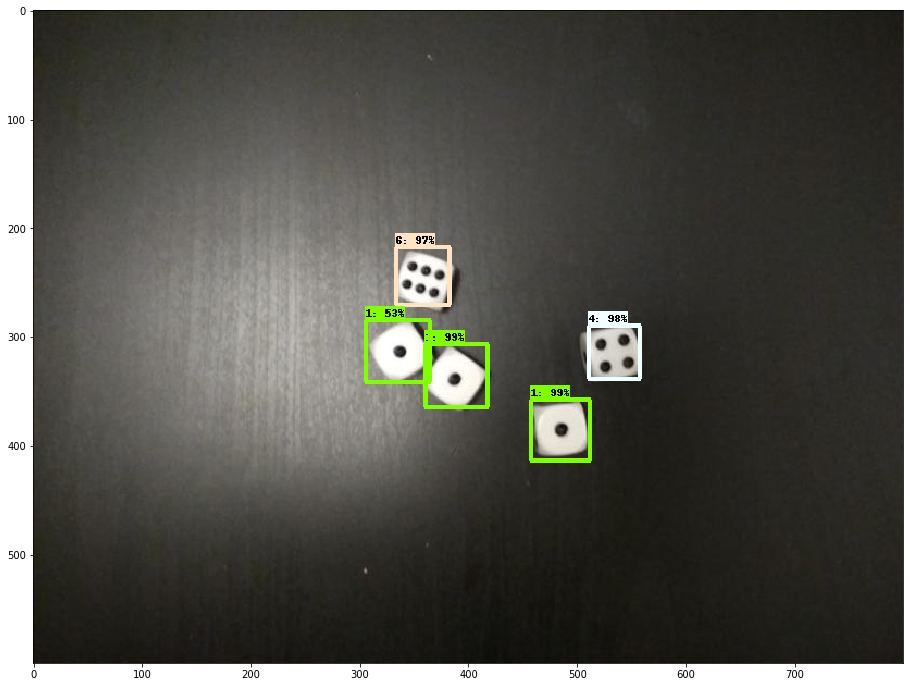

In [16]:
%matplotlib inline

PATH_TO_MODEL = "/content/training_demo/training/output_inference_graph_v1.pb/frozen_inference_graph.pb"
PATH_TO_LABELS = "/content/training_demo/annotations/label_map.pbtxt"

PATH_TO_IMAGE = "/content/training_demo/images/test/70.jpg"

NUM_CLASSES = 6

# Load a model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

# Load labels
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:

      image = Image.open(PATH_TO_IMAGE)
      
      # Convert image to numpy array
      (im_width, im_height) = image.size    
      image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)      
    
      image_np_expanded = np.expand_dims(image_np, axis=0)
      
      # Extract image tensor
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      
      # Extract detection boxes
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      
      # Extract detection scores
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      
      # Extract detection classes
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      
      # Extract number of detectionsd
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
     
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=4,
          min_score_thresh = 0.3
          )
     
      IMAGE_SIZE = (18, 12)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)  

Далее конвертацуем в модель совместимую с tflite_convert. 
Параметры такие же как и в export_inference_graph.py выше.


In [0]:
!python /content/models/research/object_detection/export_tflite_ssd_graph.py --pipeline_config_path /content/training_demo/training/ssdlite_mobilenet_v2_coco.config --trained_checkpoint_prefix /content/training_demo/training/model.ckpt-[CHECKPOINT_NUMBER] --output_directory /content/training_demo/training/output_inference_graph_tf_lite_v1.pb

Конвертируем модель в формат tflite:

In [0]:
!tflite_convert --output_file=/content/training_demo/training/model_q.tflite  --graph_def_file=/content/training_demo/training/output_inference_graph_tf_lite_v1.pb/tflite_graph.pb --input_arrays=normalized_input_image_tensor  --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --input_shapes=1,300,300,3 --enable_select_tf_ops --allow_custom_ops  --inference_input_type=QUANTIZED_UINT8 --inference_type=FLOAT --mean_values=128 --std_dev_values=128

Архивируем папку с результатами обучения и заливаем её в Google Drive:



In [0]:
!zip -r ./training_demo/training.zip ./training_demo/training/

In [0]:
training_result = drive.CreateFile({'title': 'training_result.zip'})
training_result.SetContentFile('training_demo/training.zip')
training_result.Upload()

Если возникнет ошибка:
```
InvalidConfigError: Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)
```
нужно повторно авторизоваться

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)